In [1]:
import numpy as np
from scipy import signal
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
# import plotly.io as pio
import mne
import json
import glob
import os
from tqdm import tqdm
import time
from datetime import timedelta
from braindecode.datasets import BaseConcatDataset
from mne_features.feature_extraction import FeatureExtractor
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import TSclassifier, MDM, FgMDM
from pyriemann.utils.distance import distance_riemann, distance_euclid, distance_logeuclid
from pyriemann.utils.mean import mean_riemann, mean_euclid, mean_logeuclid
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics as metrics
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, self_subject_label_alignment, relabel_dataset
from collections import defaultdict
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore') 

In [2]:
%%time
# fmt: off
subjects = [
    'K001', 'K002', 'K003', 'K004', 'K005', 
    'K006', 'K007', 'K008', 'K009', 'K010', 
    'K011', 'K012', 'K013', 'K015', 'K016', 
    'K017', 'K018', 'K021', 'K022', 'K023', 
    'K024', 'K025', 'K026', 'K027', 'K028', 
    'K300', 'K301', 'K302', 'K303', 'K304', 
    'K305', 'K306', 'K307', 'K308', 'K309', 
    'K310', 'K311', 'K312', 'K313', 'K314', 
    'K315', 'K316', 'K319', 'K320', 'K321', 
    'K322', 'K323', 'K324', 'K325', 'K326', 
    'K327', 'K328', 'K329', 'K330', 'K331', 
    'K332', 'K333', 'K334', 'K335', 'K336', 
    'K337', 'K338', 'K339', 'K342', 'K343', 
    'K344', 'K350', 'K351', 'K352', 'K353', 
    'K354', 'K355', 'K357', 'K358', 'K359', 
    'K360', 'K361', 'K362', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    "há miệng",
]

events = [
    "Thinking",
    "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    # "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "FC5", "FC1", "FC2", "FC6",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    # "PO9", "O1", "Oz", "O2", "PO10",
    "O1", "Oz", "O2",
]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    # "nâng tay trái_Thinking": "nâng tay",
    # "nâng tay phải_Thinking": "nâng tay",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    # "nâng chân trái_Thinking": "nâng chân",
    # "nâng chân phải_Thinking": "nâng chân",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    # "gật đầu_Thinking": "gật/lắc đầu",
    # "lắc đầu_Thinking": "gật/lắc đầu",
    "há miệng_Thinking": "há miệng",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

max_duration = {  # seconds
    # "nâng tay trái": 10,
    # "nâng tay phải": 10,
    # "nâng chân trái": 10,
    # "nâng chân phải": 10,
    # "gật đầu": 10,
    # "lắc đầu": 10,
    "rest": 20,
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 2  # @param
window_stride_duration = 0.5  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

moving_standardize = False  # @param {"type": "boolean"}

ds = load_data(
    "../data/DataVIN/Official",  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

als_subjects = [
    *(f"ALS01_t{i}" for i in range(1, 11)),
    *(f"ALS02_t{i}" for i in range(1, 11)),
    *(f"ALS03_t{i}" for i in range(1, 8)),
    *(f"ALS04_t{i}" for i in range(1, 6)),
    *(f"ALS05_t{i}" for i in range(1, 5)),
    *(f"ALS06_t{i}" for i in range(1, 4)),
]

als_ds = load_data(
    "../data/DataVIN/ALS/als-patients",  
    subjects=als_subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    max_duration=max_duration,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=moving_standardize,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

# ds = als_ds
# subjects = als_subjects

ds = BaseConcatDataset([ds, als_ds])
subjects.extend(als_subjects)

# fmt: on

# for _ds in ds.datasets:
#     _ds_info = _ds.description
#     if _ds_info["subject"] == "ALS01_t2":
#         _ds_info["subject"] = "ALS01_t1"
#     elif _ds_info["subject"] == "ALS01_t4":
#         _ds_info["subject"] = "ALS01_t3"
#     elif _ds_info["subject"] == "ALS01_t6":
#         _ds_info["subject"] = "ALS01_t5"

# list_of_ds = list()
# for _ds in ds.datasets:
#     if _ds.description["label"] == "rest" and _ds.description["trial"] > 2:
#         continue
#     list_of_ds.append(_ds)
    
# ds = BaseConcatDataset(list_of_ds)
# del list_of_ds
        
ds_info = ds.description

ds_info["epochs"] = 0
for i, r in ds_info.iterrows():
    ds_info.loc[i, "epochs"] = len(ds.datasets[i].windows)

print(f"loaded {len(ds_info['subject'].unique())} subjects - {ds_info['epochs'].sum()} epochs")
ds_info

using 28 channels


trial: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1616/1616 [00:06<00:00, 265.91it/s]


loaded 129 subjects - 77676 epochs
CPU times: user 2min 13s, sys: 5.45 s, total: 2min 18s
Wall time: 2min 19s


,subject,scenario,event,onset,label,label_idx,trial,split,epochs
0,K001,nâng tay trái,Thinking,6.7125,nâng tay trái,7,0,train,9
1,K001,nâng tay trái,Resting,13.1479,rest,0,0,train,10
2,K001,nâng tay trái,Thinking and Acting,19.9070,nâng tay trái,7,0,train,22
3,K001,nâng tay trái,Resting,32.7215,rest,0,1,train,5
4,K001,nâng tay trái,Thinking,37.0182,nâng tay trái,7,1,train,10
...,...,...,...,...,...,...,...,...,...
7257,ALS06_t3,lắc đầu,Thinking,4.3345,lắc đầu,3,0,train,20
7258,ALS06_t3,lắc đầu,Resting,15.9186,rest,0,0,train,12
7259,ALS06_t3,lắc đầu,Thinking,23.5328,lắc đầu,3,1,train,23
7260,ALS06_t3,lắc đầu,Resting,36.5835,rest,0,1,train,10


8 classes
gật đầu: 4.0s-18.5s
há miệng: 4.0s-25.0s
lắc đầu: 4.0s-20.5s
nâng chân phải: 4.0s-15.0s
nâng chân trái: 4.0s-15.5s
nâng tay phải: 4.0s-13.5s
nâng tay trái: 4.0s-16.5s
rest: 4.0s-20.0s


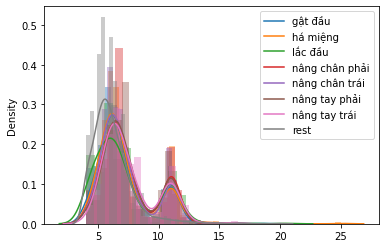

In [3]:
window_duration = 2.0  # @param
window_stride_duration = 0.5  # @param

labels = sorted(list(set(ds_info["label"])))
print(f"{len(labels)} classes")

for label in labels:
    du = list()
    for _, r in ds_info[ds_info["label"] == label].iterrows():
        du.append((r["epochs"] - 1) * window_stride_duration + window_duration)

    print(f"{label}: {min(du)}s-{max(du)}s")
    sb.distplot(du)

plt.legend(labels)

In [59]:
%%time
C = list()
S = list()
for subject in tqdm(ds_info["subject"].unique(), desc="subject"):
    X = list()
    for i in ds_info[ds_info["subject"] == subject].index:
        X.append(ds.datasets[i].windows.get_data())
    X = np.concatenate(X, axis=0)
    Cx = np.stack([np.cov(x, rowvar=True) for x in X])
    C.append(mean_riemann(Cx))
    S.append(subject)

subject: 100%|██████████████████████████████████████████████████████████████████████████████████████| 129/129 [05:15<00:00,  2.44s/it]

CPU times: user 9min 29s, sys: 20min 34s, total: 30min 3s
Wall time: 5min 15s


In [60]:
dist = list()
for i1, sub1 in tqdm(enumerate(S), desc="subject"):
    for i2, sub2 in enumerate(S):
        if i1 == i2:
            continue
            
        dist.append((sub1, sub2, distance_riemann(C[i1], C[i2])))

subject: 129it [00:02, 51.24it/s]


In [61]:
dist = pd.DataFrame(dist, columns=["subject 1", "subject 2", "distance"])
dist

,subject 1,subject 2,distance
0,K001,K002,4.712153
1,K001,K003,5.167744
2,K001,K004,4.587816
3,K001,K005,6.039429
4,K001,K006,6.368055
...,...,...,...
16507,ALS06_t3,ALS05_t2,8.501877
16508,ALS06_t3,ALS05_t3,8.470490
16509,ALS06_t3,ALS05_t4,7.459452
16510,ALS06_t3,ALS06_t1,7.706591


In [71]:
dist[dist["subject 1"] == "ALS01_t5"].sort_values("distance")[:10]

,subject 1,subject 2,distance
12254,ALS01_t5,ALS01_t4,4.143103
12255,ALS01_t5,ALS01_t6,4.176629
12251,ALS01_t5,ALS01_t10,4.306602
12253,ALS01_t5,ALS01_t3,4.397052
12250,ALS01_t5,ALS01_t1,5.402233
12252,ALS01_t5,ALS01_t2,5.539037
12256,ALS01_t5,ALS01_t7,6.348448
12258,ALS01_t5,ALS01_t9,6.426405
12259,ALS01_t5,ALS02_t1,6.442415
12271,ALS01_t5,ALS03_t3,6.982523


In [69]:
dd = dist.loc[dist.groupby("subject 1")["distance"].idxmin()]
dd[dd["subject 1"].str.contains("ALS01_t5")]

,subject 1,subject 2,distance
12254,ALS01_t5,ALS01_t4,4.143103


In [18]:
ds_info[ds_info["subject"] == "ALS01_t10"]

,subject,scenario,event,onset,label,label_idx,trial,split,epochs
3410,ALS01_t10,nâng tay trái,Thinking,6.1135,nâng tay trái,6,0,train,19
3411,ALS01_t10,nâng tay trái,Thinking,20.1915,nâng tay trái,6,1,train,19
3412,ALS01_t10,nâng tay trái,Thinking,33.8695,nâng tay trái,6,2,train,20
3413,ALS01_t10,nâng tay trái,Resting,45.3987,rest,0,0,train,5
3414,ALS01_t10,nâng tay phải,Thinking,5.7309,nâng tay phải,5,0,train,19
3415,ALS01_t10,nâng tay phải,Thinking,18.5433,nâng tay phải,5,1,train,18
3416,ALS01_t10,nâng tay phải,Thinking,31.8212,nâng tay phải,5,2,train,19
3417,ALS01_t10,nâng chân trái,Thinking,5.3773,nâng chân trái,4,0,train,19
3418,ALS01_t10,nâng chân trái,Thinking,19.6706,nâng chân trái,4,1,train,19
3419,ALS01_t10,nâng chân trái,Thinking,33.1500,nâng chân trái,4,2,train,21


In [75]:
raw = mne.io.read_raw_edf("../data/DataVIN/ALS/als-patients/ALS02_t1/sample2/EEG.edf", preload=False, verbose=False)
raw.set_montage("standard_1020")

print(pd.DataFrame(raw.annotations))

events, event_id = mne.events_from_annotations(raw)
print(event_id)
print(events)

     onset  duration description                 orig_time
0   7.6310   11.2741    Thinking 2022-01-19 12:01:02+00:00
1  18.9051   11.5043     Resting 2022-01-19 12:01:02+00:00
2  30.4104   10.7285    Thinking 2022-01-19 12:01:02+00:00
3  41.1399    5.8941     Resting 2022-01-19 12:01:02+00:00
4  47.0350   11.0639    Thinking 2022-01-19 12:01:02+00:00
5  58.0989    5.9638     Resting 2022-01-19 12:01:02+00:00
6  64.0637   49.1667      Typing 2022-01-19 12:01:02+00:00
{'Resting': 1, 'Thinking': 2, 'Typing': 3}
[[ 977    0    2]
 [2420    0    1]
 [3893    0    2]
 [5266    0    1]
 [6020    0    2]
 [7437    0    1]
 [8200    0    3]]


In [5]:
visualize_subjects = {
    'K309', 'K311', 'K312', 'K313', 'K315', 
    'K316', 'K321', 'K322', 'K323', 'K325', 
    'ALS01_t1', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5',
}

In [6]:
list_of_ds = list()
for _ds in ds.datasets:
    if _ds.description["subject"] not in visualize_subjects:
        continue
        
    list_of_ds.append(_ds)
    
ds = BaseConcatDataset(list_of_ds)
ds_info = ds.description

In [7]:
ds_info

,subject,scenario,event,onset,label,label_idx,trial,split
0,K309,nâng tay trái,Thinking,7.6669,nâng tay trái,2,0,train
1,K309,nâng tay trái,Resting,14.7153,rest,0,0,train
2,K309,nâng tay trái,Resting,29.2437,rest,0,1,train
3,K309,nâng tay trái,Thinking,35.0082,nâng tay trái,2,1,train
4,K309,nâng tay trái,Resting,41.1727,rest,0,2,train
...,...,...,...,...,...,...,...,...
209,ALS01_t5,nâng tay phải,Resting,16.2823,rest,0,0,train
210,ALS01_t5,nâng tay phải,Thinking,23.7763,nâng tay phải,1,1,train
211,ALS01_t5,nâng tay phải,Resting,34.8070,rest,0,1,train
212,ALS01_t5,nâng tay phải,Thinking,41.9041,nâng tay phải,1,2,train


In [77]:
X = list()
Y = list()
S = list()
for _ds in ds.datasets:
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    S.extend([_ds.description["subject"]] * len(_ds.y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

le = LabelEncoder()
S = le.fit_transform(S)

In [78]:
colors = "kbgrcmy"

C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

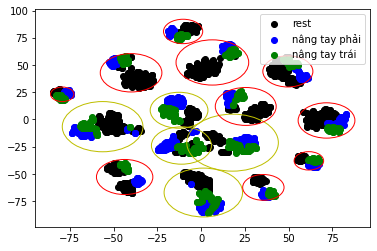

In [79]:
ax = plt.gca()
ax.cla() # clear things for fresh plot

for i, y in enumerate(np.unique(Y)):
    idx = np.where((Y == y))[0]  # target subject
    ax.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', color=colors[i])

#     idx = np.where((Y == y) & (np.logical_not(S)))[0]  # others
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='+', color=colors[i])

plt.legend(["rest", "nâng tay phải", "nâng tay trái"])

for s in np.unique(S):
    idx = np.where(S == s)[0]
    pp = feat2d[idx]
    xy = pp.mean(axis=0)
    r = xy[None] - pp
    r **= 2
    r = np.sqrt(r[:, 0] + r[:, 1]).max() + 1
    ax.add_patch(plt.Circle((xy[0], xy[1]), radius=r, color='r' if s >= 5 else 'y', fill=False))

In [80]:
ea_ds = deepcopy(ds)
euclidean_alignment(ea_ds, target_subject=None)

subject: 100%|███████████████████████████████████████████████████████| 15/15 [00:00<00:00, 62.70it/s]


In [81]:
X = list()
Y = list()
S = list()
for _ds in ea_ds.datasets:
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    S.extend([_ds.description["subject"]] * len(_ds.y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

le = LabelEncoder()
S = le.fit_transform(S)

In [82]:
colors = "kbgrcmy"

C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

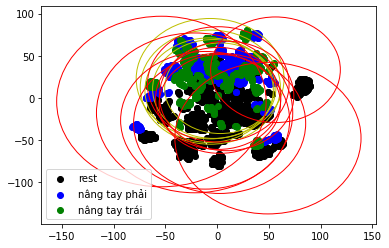

In [83]:
ax = plt.gca()
ax.cla() # clear things for fresh plot

for i, y in enumerate(np.unique(Y)):
    idx = np.where((Y == y))[0]  # target subject
    ax.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', color=colors[i])

#     idx = np.where((Y == y) & (np.logical_not(S)))[0]  # others
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='+', color=colors[i])

plt.legend(["rest", "nâng tay phải", "nâng tay trái"])

for s in np.unique(S):
    idx = np.where(S == s)[0]
    pp = feat2d[idx]
    xy = pp.mean(axis=0)
    r = xy[None] - pp
    r **= 2
    r = np.sqrt(r[:, 0] + r[:, 1]).max() + 1
    ax.add_patch(plt.Circle((xy[0], xy[1]), radius=r, color='r' if s >= 5 else 'y', fill=False))

In [84]:
la_ds = deepcopy(ds)

for _ds in la_ds.datasets:
    if _ds.description["subject"].startswith("ALS"):
        setattr(_ds.description, "session", _ds.description["subject"])
        _ds.description["subject"] = "ALS"
        
label_alignment(la_ds, target_subject="ALS", metric="logeuclid")

for _ds in la_ds.datasets:
    if hasattr(_ds.description, "session"):
        _ds.description["subject"] = getattr(_ds.description, "session")

subject: 100%|███████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.51it/s]


In [85]:
X = list()
Y = list()
S = list()
for _ds in la_ds.datasets:
    X.append(_ds.windows.get_data())
    Y.extend(_ds.y)
    S.extend([_ds.description["subject"]] * len(_ds.y))
    
X = np.concatenate(X, axis=0)
Y = np.array(Y, dtype=int)

le = LabelEncoder()
S = le.fit_transform(S)

In [86]:
colors = "kbgrcmy"

C = np.stack([np.cov(x, rowvar=True) for x in X])
feat = TangentSpace(metric="riemann").fit_transform(C)
feat2d = TSNE(n_components=2).fit_transform(feat)

In [87]:
le.classes_

array(['ALS01_t1', 'ALS01_t2', 'ALS01_t3', 'ALS01_t4', 'ALS01_t5', 'K309',
       'K311', 'K312', 'K313', 'K315', 'K316', 'K321', 'K322', 'K323',
       'K325'], dtype='<U8')

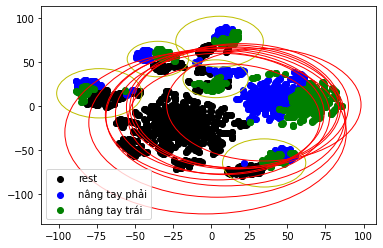

In [88]:
ax = plt.gca()
ax.cla() # clear things for fresh plot

for i, y in enumerate(np.unique(Y)):
    idx = np.where((Y == y))[0]  # target subject
    ax.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='o', color=colors[i])

#     idx = np.where((Y == y) & (np.logical_not(S)))[0]  # others
#     plt.scatter(feat2d[idx, 0], feat2d[idx, 1], marker='+', color=colors[i])

plt.legend(["rest", "nâng tay phải", "nâng tay trái"])

for s in np.unique(S):
    idx = np.where(S == s)[0]
    pp = feat2d[idx]
    xy = pp.mean(axis=0)
    r = xy[None] - pp
    r **= 2
    r = np.sqrt(r[:, 0] + r[:, 1]).max() + 1
    ax.add_patch(plt.Circle((xy[0], xy[1]), radius=r, color='r' if s >= 5 else 'y', fill=False))

In [5]:
for sub in glob.glob("../data/DataVIN/ALS/als-patients/ALS01*"):
    with open(f"{sub}/info.json", mode="r", encoding="utf-8") as f:
        print(json.load(f))

{'id': 'ALS01_t1', 'name': 'Nguyễn Xuân Biên', 'age': 43, 'gender': 'M'}
{'id': 'ALS01_t4', 'name': 'Nguyễn Xuân Biên', 'age': 44, 'gender': 'M'}
{'id': 'ALS01_t5', 'name': 'Nguyễn Xuân Biên', 'age': 36, 'gender': 'M'}
{'id': 'ALS01_t8', 'name': 'Nguyễn Xuân Biên', 'age': 43, 'gender': 'M'}
{'id': 'ALS01_t9', 'name': 'Nguyễn Xuân Biên', 'age': 43, 'gender': 'M'}
{'id': 'ALS01_t7', 'name': 'Nguyễn Xuân Biên', 'age': 43, 'gender': 'M'}
{'id': 'ALS01_t2', 'name': 'Nguyễn Xuân Biên', 'age': 36, 'gender': 'M'}
{'id': 'ALS01_t7', 'name': 'Nguyễn Xuân Biên', 'age': 43, 'gender': 'M'}
{'id': 'ALS01_t10', 'name': 'Nguyễn Xuân Biên', 'age': 43, 'gender': 'M'}
{'id': 'ALS01_t6', 'name': 'Nguyễn Xuân Biên', 'age': 46, 'gender': 'M'}


In [20]:
from datetime import timedelta

date = list()
for sub in glob.glob("../data/DataVIN/ALS/als-patients/ALS06_*"):
    raw = mne.io.read_raw_edf(f"{sub}/sample1/EEG.edf", verbose=False)
    date.append(raw.info["meas_date"])
    
date = sorted(date)

for i in range(1, len(date)):
    # print(timedelta(date[i], date[i - 1]))
    print(date[i] - date[i - 1])

6 days, 21:00:19
7 days, 0:42:23
